In [1]:
# %% [markdown]
# # Cell 1: Đọc và xử lý dữ liệu, xử lý NaN trong cột Vol.

# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "../../../Dataset/Splits/train_60_20_20.csv"
VAL_FILE   = "../../../Dataset/Splits/val_60_20_20.csv"
TEST_FILE  = "../../../Dataset/Splits/test_60_20_20.csv"

train_df = pd.read_csv(TRAIN_FILE, parse_dates=["Date"])
val_df = pd.read_csv(VAL_FILE, parse_dates=["Date"])
test_df = pd.read_csv(TEST_FILE, parse_dates=["Date"])

def parse_value(x):
    if isinstance(x, str):
        s = x.replace('$','').replace(',','')
        if s.endswith('%'): return float(s[:-1])
        if s.endswith('K'): return float(s[:-1]) * 1e3
        if s.endswith('M'): return float(s[:-1]) * 1e6
        return float(s)
    return x

def clean_df(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(parse_value)
    return df

train_df = clean_df(train_df)
val_df = clean_df(val_df)
test_df = clean_df(test_df)

# Gộp dữ liệu
df_all = pd.concat([train_df, val_df, test_df]).sort_values("Date").reset_index(drop=True)

# Thay NaN trong cột Vol. bằng giá trị trung bình
vol_mean = df_all['Vol.'].mean()
df_all['Vol.'].fillna(vol_mean, inplace=True)

# Thêm các đặc trưng thời gian & kỹ thuật
df_all["day_of_week"] = df_all["Date"].dt.dayofweek
df_all["month"] = df_all["Date"].dt.month
df_all["rolling_mean_5"] = df_all["Price"].rolling(window=5).mean()
df_all["rolling_std_5"] = df_all["Price"].rolling(window=5).std()
df_all["return_1d"] = df_all["Price"].pct_change()

# Kiểm tra số lượng NaN
nan_counts = df_all.isna().sum()
print("Số lượng giá trị NaN từng cột sau xử lý Vol.:")
print(nan_counts)

# Drop NaN còn lại do rolling và pct_change tạo ra
df_all.dropna(inplace=True)

feature_cols = ["Price", "Open", "High", "Low", "Vol.", "Change %", "CPIAUCSL",
                "day_of_week", "month", "rolling_mean_5", "rolling_std_5", "return_1d"]

scaler = StandardScaler()
df_all[feature_cols] = scaler.fit_transform(df_all[feature_cols])


Số lượng giá trị NaN từng cột sau xử lý Vol.:
Date              0
Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
CPIAUCSL          0
day_of_week       0
month             0
rolling_mean_5    4
rolling_std_5     4
return_1d         1
dtype: int64


C:\Users\quyen\AppData\Local\Temp\ipykernel_11100\1909129143.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Vol.'].fillna(vol_mean, inplace=True)


In [2]:
# %% [markdown]
# # Cell 2: Chuẩn bị dữ liệu chuỗi (lagged)

# %%
SEQ_LEN = 90

def create_multivariate_lagged(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])
        y.append(data[i, 0])  # target là Price
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(df_all[feature_cols].values, SEQ_LEN)

n_train = len(train_df) - SEQ_LEN
n_val = len(val_df)

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train+n_val]
X_test = X_all[n_train+n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train+n_val]
y_test = y_all[n_train+n_val:]


In [3]:
# %% [markdown]
# # Cell 3: Tạo DataLoader PyTorch

# %%
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
), batch_size=32, shuffle=False)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
), batch_size=32)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
), batch_size=32)


In [4]:
# %% [markdown]
# # Cell 4: Định nghĩa mô hình WaveNet

# %%
import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, dilation, in_ch, out_ch, kernel_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, dilation=dilation, padding='same')
        self.relu = nn.ReLU()
        self.skip = nn.Conv1d(out_ch, in_ch, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv(x))
        skip = self.skip(out)
        if skip.size(2) != x.size(2):
            min_len = min(skip.size(2), x.size(2))
            x = x[:, :, :min_len]
            skip = skip[:, :, :min_len]
        return x + skip, skip

class WaveNet(nn.Module):
    def __init__(self, in_ch, out_ch=32, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(d, in_ch, out_ch) for d in dilations
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, C, T
        skip_total = None
        for block in self.blocks:
            x, skip = block(x)
            skip_total = skip if skip_total is None else skip_total + skip
        x = self.dropout(skip_total)
        x = x.mean(dim=2)  # Global average pooling
        return self.fc(x).squeeze(1)


In [5]:
# %% [markdown]
# # Cell 5: Khởi tạo model, optimizer, loss

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNet(in_ch=X_train.shape[2]).to(device)

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [6]:
# %% [markdown]
# # Cell 6: Huấn luyện model

# %%
from tqdm import tqdm

EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_wavenet.pt")


c:\Users\quyen\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 01 | Train Loss: 0.3660 | Val Loss: 0.4489
Epoch 02 | Train Loss: 0.1428 | Val Loss: 0.3663
Epoch 03 | Train Loss: 0.0759 | Val Loss: 0.2484
Epoch 04 | Train Loss: 0.0515 | Val Loss: 0.1598
Epoch 05 | Train Loss: 0.0399 | Val Loss: 0.1170
Epoch 06 | Train Loss: 0.0355 | Val Loss: 0.1005
Epoch 07 | Train Loss: 0.0329 | Val Loss: 0.0952
Epoch 08 | Train Loss: 0.0319 | Val Loss: 0.0941
Epoch 09 | Train Loss: 0.0308 | Val Loss: 0.0939
Epoch 10 | Train Loss: 0.0294 | Val Loss: 0.0939
Epoch 11 | Train Loss: 0.0283 | Val Loss: 0.0949
Epoch 12 | Train Loss: 0.0271 | Val Loss: 0.0956
Epoch 13 | Train Loss: 0.0264 | Val Loss: 0.0966
Epoch 14 | Train Loss: 0.0250 | Val Loss: 0.0981
Epoch 15 | Train Loss: 0.0242 | Val Loss: 0.0994
Epoch 16 | Train Loss: 0.0232 | Val Loss: 0.1008
Epoch 17 | Train Loss: 0.0222 | Val Loss: 0.1022
Epoch 18 | Train Loss: 0.0213 | Val Loss: 0.1040
Epoch 19 | Train Loss: 0.0205 | Val Loss: 0.1052
Epoch 20 | Train Loss: 0.0196 | Val Loss: 0.1088
Epoch 21 | Train Los

In [11]:
# %% [markdown]
# # Cell 7: Đánh giá model trên test set (trả dữ liệu về gốc)

# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.load_state_dict(torch.load("best_wavenet.pt"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

# Inverse transform về dữ liệu gốc (giá vàng thực tế)
y_preds_inv = y_preds * scaler.scale_[0] + scaler.mean_[0]
y_trues_inv = y_trues * scaler.scale_[0] + scaler.mean_[0]

# Tính MAE, RMSE, MAPE, R², Adjusted R² trên dữ liệu gốc
mae = mean_absolute_error(y_trues_inv, y_preds_inv)
rmse = mean_squared_error(y_trues_inv, y_preds_inv, squared=False)
mape = np.mean(np.abs((y_trues_inv - y_preds_inv) / y_trues_inv)) * 100
r2 = r2_score(y_trues_inv, y_preds_inv)
n = len(y_trues_inv)
p = X_train.shape[2]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R²        : {r2:.4f}")
print(f"Adj R²    : {adj_r2:.4f}")


MAE       : 192.5431
RMSE      : 224.5796
MAPE      : 8.55%
R²        : 0.6194
Adj R²    : 0.6134


In [12]:
# %% [markdown]
# # Cell 8: Dự báo 90 ngày tương lai (trả dữ liệu về gốc)

# %%
model.eval()
input_seq = torch.tensor(X_test[-1:], dtype=torch.float32).to(device)

forecast_scaled = []
with torch.no_grad():
    for _ in range(90):
        y_next = model(input_seq).cpu().item()
        forecast_scaled.append(y_next)

        new_input = input_seq[:, 1:, :].clone()
        new_step = new_input[:, -1:, :].clone()
        new_step[:, :, 0] = y_next
        input_seq = torch.cat([new_input, new_step], dim=1)

# Inverse transform về dữ liệu gốc
forecast_inv = np.array(forecast_scaled) * scaler.scale_[0] + scaler.mean_[0]


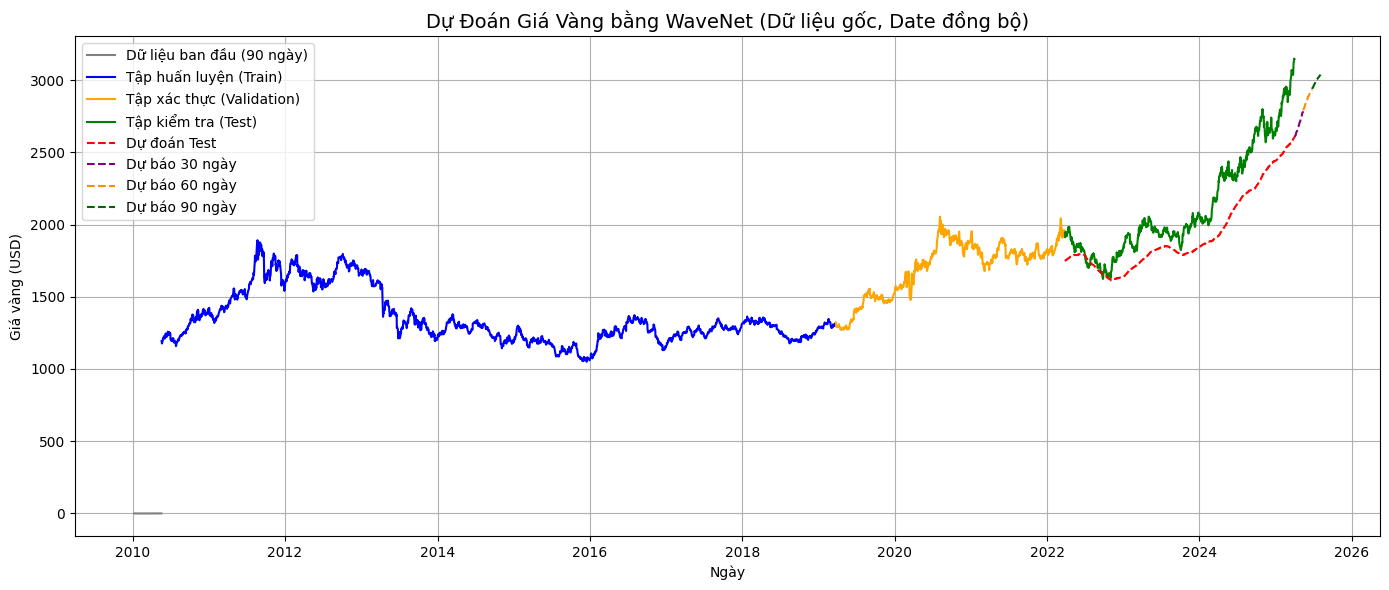

In [14]:
# %% [markdown]
# # Cell 9: Vẽ kết quả dự báo (dữ liệu gốc, Date đồng bộ)

# %%
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import BDay

target_col = "Price"
SEQ_LEN = 90

# Lấy số lượng từng tập
train_len = len(X_train)
val_len = len(X_val)
test_len = len(X_test)

# Tính chỉ số trong df_all để khớp Date với từng tập
train_start_idx = SEQ_LEN
val_start_idx = train_start_idx + train_len
test_start_idx = val_start_idx + val_len

train_dates = df_all['Date'].iloc[train_start_idx:train_start_idx + train_len].reset_index(drop=True)
val_dates = df_all['Date'].iloc[val_start_idx:val_start_idx + val_len].reset_index(drop=True)
test_dates = df_all['Date'].iloc[test_start_idx:test_start_idx + test_len].reset_index(drop=True)

plt.figure(figsize=(14, 6))

# Vẽ dữ liệu ban đầu (chỉ 90 ngày đầu tiên cho minh họa)
plt.plot(df_all['Date'][:90], df_all[target_col].values[:90], color='gray', label='Dữ liệu ban đầu (90 ngày)')

# Vẽ từng tập với Date đúng
plt.plot(train_dates, y_train * scaler.scale_[0] + scaler.mean_[0], color='blue', label='Tập huấn luyện (Train)')
plt.plot(val_dates, y_val * scaler.scale_[0] + scaler.mean_[0], color='orange', label='Tập xác thực (Validation)')
plt.plot(test_dates, y_trues_inv, color='green', label='Tập kiểm tra (Test)')

# Dự đoán Test (Date đồng bộ)
plt.plot(test_dates, y_preds_inv, color='red', linestyle='--', label='Dự đoán Test')

# Dự báo 90 ngày (Date tính từ cuối Test)
try:
    last_test_date = pd.to_datetime(test_dates.iloc[-1])
    full_forecast = np.concatenate([y_preds_inv[-1:], forecast_inv])
    full_dates = pd.date_range(last_test_date, periods=len(full_forecast), freq=BDay())

    plt.plot(full_dates[1:31], full_forecast[1:31], color='purple', linestyle='--', label='Dự báo 30 ngày')
    plt.plot(full_dates[31:61], full_forecast[31:61], color='darkorange', linestyle='--', label='Dự báo 60 ngày')
    plt.plot(full_dates[61:], full_forecast[61:], color='darkgreen', linestyle='--', label='Dự báo 90 ngày')
except NameError:
    pass

plt.title("Dự Đoán Giá Vàng bằng WaveNet (Dữ liệu gốc, Date đồng bộ)", fontsize=14)
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
!jupyter nbconvert --to html WaveNet_60-20-20.ipynb

[NbConvertApp] Converting notebook WaveNet_60-20-20.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 444438 bytes to WaveNet_60-20-20.html
